#Import Libraries and Mount drive

In [ ]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.utils import resample
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

#Load Dataset and Downsampled Adaptive to balance the classes

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df = pd.read_excel(file_path)

# Drop irrelevant columns (keeping text and labels)
df = df[['text_ner', 'Adaptive']]

# Rename columns for clarity
df.columns = ['text', 'label']

# Drop missing values
df.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df['binary_label'] = df['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)


# Check dataset distribution
print("Original Data Distribution:")
print(df['binary_label'].value_counts())

# Separate adaptive and maladaptive cases
adaptive = df[df['binary_label'] == 0]
maladaptive = df[df['binary_label'] == 1]

# Downsample adaptive to match maladaptive count
adaptive_downsampled = resample(adaptive,
                                replace=False,
                                n_samples=len(maladaptive),
                                random_state=42)

# Combine new balanced dataset
df_balanced = pd.concat([adaptive_downsampled, maladaptive])

# Check new distribution
print("\nBalanced Data Distribution:")
print(df_balanced['binary_label'].value_counts())

Load tokenizer and Define Custom Dataset class

In [ ]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Set Random Seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Tokenize the text data
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare dataset
texts = df_balanced['text'].tolist()
labels = df_balanced['binary_label'].tolist()

# Split data into train-test sets (80-20 split) with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=42)

# Create datasets
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#Load Model and Train Model

In [ ]:
# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
model.train()
for epoch in range(10):  # Adjust number of epochs as needed
    for batch in train_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
y_true, y_pred, y_pred_proba = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
        attention_mask = batch['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')
        labels = batch['label'].to('cuda' if torch.cuda.is_available() else 'cpu')

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)[:, 1]

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(probs.cpu().numpy())

#Evaluation of Model Performance: ROC-AUC, Classification Report, and Confusion Matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Data Distribution:
binary_label
0    387
1    113
Name: count, dtype: int64

Balanced Data Distribution:
binary_label
0    113
1    113
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.57      0.58        23
           1       0.58      0.61      0.60        23

    accuracy                           0.59        46
   macro avg       0.59      0.59      0.59        46
weighted avg       0.59      0.59      0.59        46


Confusion Matrix:
[[13 10]
 [ 9 14]]


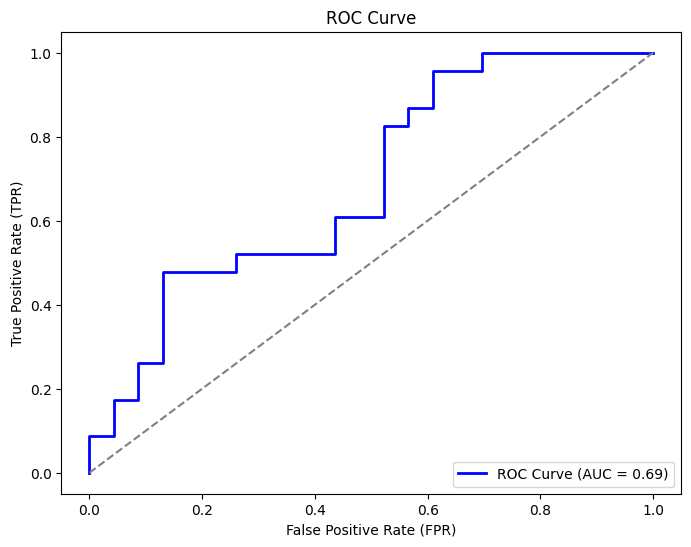

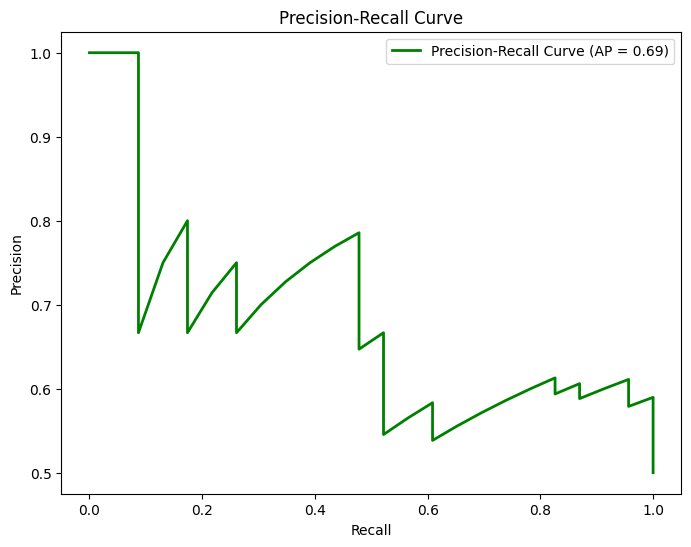

In [ ]:
# Evaluate model
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
average_precision = average_precision_score(y_true, y_pred_proba)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()